In [200]:
from proteinworkshop.features.factory import ProteinFeaturiser
from proteinworkshop.datasets.utils import create_example_batch
#from proteinworkshop.models.graph_encoders.schnet import SchNetModel
from torch.utils.data import Dataset
import pickle
import pdbreader
from torch.utils.data import DataLoader
import graphein.protein.tensor as gpt


with open("splits/prototype/train.pkl",'rb') as f:
    train = pickle.load(f)

with open("splits/prototype/val.pkl",'rb') as f:
    val = pickle.load(f)

with open("splits/prototype/test.pkl",'rb') as f:
    test = pickle.load(f)


In [201]:
trainnames = [x["id"] for x in train]
testnames = [x["id"] for x in test]
valnames = [x["id"] for x in val]



create a label dicts for all sets

In [202]:
trainlabels = {}
for prot in train:
    trainlabels[prot["id"]]=prot["labels"]

vallabels = {}
for prot in val:
    vallabels[prot["id"]]=prot["labels"]

testlabels = {}
for prot in test:
    testlabels[prot["id"]]=prot["labels"]



In [192]:
print(trainlabels["P10384"])

SSSSSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBPPPPPPPPBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBPPPPPPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBPPPPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBBPPPPBBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBBPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOBBBBBBBBBPPPPBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOBBBBBBBPP


In [29]:


# class transmembraneDataset(Dataset):
#     def __init__(self,data_li,path):
#         self.protein_names = [x["id"] for x in data_li]
#         self.residue_sequnces = [x["sequence"] for x in data_li]
#         self.label_sequences = [x["labels"] for x in data_li]        
#         self.pdb_path = path
        

#     def __len__(self):
#         return len(self.label_sequences)

#     def __getitem__(self,idx):
#         name = self.protein_names[idx]
#         pdb_file_path = self.pdb_path + name + ".pdb" #todo: read graph-tensor instead
#         pdb_file = pdbreader.read_pdb(pdb_file_path)
#         label = self.label_sequences[idx]
#         return name, pdb_file_path, label


# train_dataloader = DataLoader(transmembraneDataset(train,"data/graphein_downloads/train/"),batch_size=1,shuffle=True)


In [32]:
# name, path, label = next(iter(train_dataloader))
# print(name)
# print(path)
# print(label)

('Q9P7M9',)
('data/graphein_downloads/train/Q9P7M9.pdb',)
('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',)


Test if we can throw it to PyG Data object

In [13]:
# data = gpt.io.protein_to_pyg(path=path[0],
#     chain_selection=["A", "B", "C", "D"], # Select all 4 chains
#     deprotonate=True, # Deprotonate the structure
#     keep_insertions=False, # Remove insertions
#     keep_hets=[], # Remove HETATMs
#     model_index=1, # Select the first model
#     # Can select a subset of atoms with atom_types=...
#     )

# protein = gpt.Protein().from_data(data)

In [14]:
# print(protein)

Protein(fill_value=1e-05, atom_list=[37], coords=[277, 37, 3], chains=[277], residue_id=[277], id='Q05892_ABCD', residue_type=[277], residues=[277])


Create necessary batch attributes

```
def required_batch_attributes(self) -> Set[str]:
        """
        Required batch attributes for this encoder.

        - ``x``: Node features (shape: :math:`(n, d)`)
        - ``pos``: Node positions (shape: :math:`(n, 3)`)
        - ``edge_index``: Edge indices (shape: :math:`(2, e)`)
        - ``batch``: Batch indices (shape: :math:`(n,)`)

        :return: Set of required batch attributes
        :rtype: Set[str]
        """
        return {"pos", "edge_index", "x", "batch"}

```

In [16]:
# protein.batch = protein.coords
# protein.edges("knn_8",cache="edge_index")
# protein.pos = protein.coords[:,1,:]
# protein.x = protein.residue_type
# print(protein)


Protein(fill_value=1e-05, atom_list=[37], coords=[277, 37, 3], chains=[277], residue_id=[277], id='Q05892_ABCD', residue_type=[277], residues=[277], batch=[277, 37, 3], edge_index=[2, 2216], pos=[277, 3], x=[277])


Batchify, load model and CA-featuriser

In [20]:
# batch = gpt.data.ProteinBatch().from_protein_list([protein])
# model = SchNetModel()
# featuriser = ProteinFeaturiser( #note: input is a protein Batch
#     representation="CA",
#     scalar_node_features=["amino_acid_one_hot"],
#     vector_node_features=[],
#     edge_types=["knn_16"],
#     scalar_edge_features=["edge_distance"],
#     vector_edge_features=[],
# )

# features_batch = featuriser(batch)

# output = model.forward(features_batch) #returns a dictionary 

In [23]:
# print(output.keys())


dict_keys(['node_embedding', 'graph_embedding'])


In [26]:
# print(output["node_embedding"].shape)
# print(output["graph_embedding"]) #im guessing this is hidden state 

torch.Size([277, 1])
tensor([[-9.7991]], grad_fn=<ScatterAddBackward0>)


So it seems to work. Now let's implement a PyG pipeline which does the same thing but with all the additional stuff included in the dataloader instance

In [217]:
from torch_geometric.data import Dataset as gDataset
from torch_geometric.loader import DataLoader
import glob
import os.path as osp
import torch 
from graphein.protein.utils import download_alphafold_structure
import os


class transmembraneGraphDataset(gDataset):
    """root: where the dataset should be stored"""
    def __init__(self, root, setType, proteinlist, labelDict, flush_files = False, transform=None, pre_transform=None,pre_filter=None):
        self.proteinlist = proteinlist
        self.conversionDict = {} #save data-conversion table between saved pt files and proteinnames
        self.root_local = root
        self.setType = setType
        self.labels = labelDict
        self.flush_files = flush_files
        print("self root local: ",self.root_local)
        print("protein list: ")
        print(self.proteinlist)
        #print("pdb dir: ",self.pdb_dir)
        super().__init__(root, transform, pre_transform, pre_filter)

    
    @property ##source directory of files - this is pdb-files in this case 
    def raw_file_names(self): #returns a list of all paths valid for entries in proteinlist
        #full_file_list = glob.glob(self.pdb_dir+"/*.pdb") #get all downloaded paths
        full_file_list = glob.glob(self.root_local+"raw/*.pdb") #get all downloaded paths
        
        #find matches so it matches the split
        res = list(
            set([sub1 for ele1 in full_file_list for sub1 in self.proteinlist if sub1 in ele1]))
        self.proteinlist = res #NOTE: OVERWRITES VALID FILES
        #res = [self.pdb_dir + x +".pdb" for x in res]
        #print(res)
        res = [x +".pdb" for x in res]
        #print("RESULTING RAW FILENAMES")
        #print(res)

        return res ###need to check it works when class is fully implemented

    @property
    def processed_file_names(self):
        #if we want to save as proteinid.pt
        #tmp = self.proteinlist
        #return [x.replace(".pdb",".pt") for x in tmp] #corresponding names with tensor extension
        return [self.setType+"_"+"protein_ "+ str(i) + ".pt" for i,_ in enumerate(self.proteinlist)]

    def download(self):    
        for protein_name in self.proteinlist:
            _ = download_alphafold_structure(protein_name, version=4,out_dir = self.root_local+"raw/", aligned_score=True)
        return
    
    def process(self):
        idx = 0
        #print("raw paths: ")
        #for raw_path in self.raw_paths: #this one adds a /raw/ for some reason
         #   print(raw_path)

        #print("Processed dir: ",self.processed_dir)
        all_files_tmp = glob.glob(osp.join(self.processed_dir, f'{self.setType}_protein_*.pt'))
        if(len(all_files_tmp)==len(self.proteinlist) and self.flush_files==False): ##case: all proteins are present
            print(f"Length of proteinnames {len(self.proteinlist)} is == to length of existing proteins in processed dir {len(all_files_tmp)}")
            return

        for i, raw_path in enumerate(self.raw_paths): #TODO: NEED TO IMPLEMENT THAT IF FILE ALREADY EXISTS, DON'T RUN PROCESS 
            print(f"running protein {i}/{len(self.raw_paths)} in set: {self.setType}")
            tmp_file_check = osp.join(self.processed_dir, f'{self.setType}_protein_{idx}.pt')
            if(os.path.isfile(tmp_file_check) and self.flush_files==False): #case: some files may already exist due to interruption of earlier command
                pass
            else:
                data = gpt.io.protein_to_pyg(path=raw_path,
                    chain_selection=["A", "B", "C", "D"], # Select all 4 chains
                    deprotonate=True, # Deprotonate the structure
                    keep_insertions=False, # Remove insertions
                    keep_hets=[], # Remove HETATMs
                    model_index=1) # Select the first model
                    # Can select a subset of atoms with atom_types=...
                
                #print(data)
                id = data["id"].replace("_ABCD","")#remove chain selection in naming for saving to dictionary
                #print("working on protein: f{id}")
                protein = gpt.Protein().from_data(data) #load protein from pdb-data
                #add edges etc
                protein.batch = protein.coords
                protein.edges("knn_8",cache="edge_index")
                protein.pos = protein.coords[:,1,:]
                protein.x = protein.residue_type
                #print(protein)
                if self.pre_filter is not None and not self.pre_filter(data):
                    continue

                if self.pre_transform is not None:
                    protein = self.pre_transform(protein)

                protein.label = self.labels[id] #fetch labelled sequence for the given protein and assign to graph-field
                
                protein = protein.to_data() #returns a torch geometric data object used for batching https://github.com/a-r-j/graphein/blob/master/graphein/protein/tensor/data.py#L266
                #save conversion for later reference in case all goes south
                self.conversionDict[id] = f'{self.setType}_protein_{idx}.pt'
                #print("the path join has arg:")
                #print(osp.join(self.processed_dir, f'protein_{idx}.pt'))
                torch.save(protein, osp.join(self.processed_dir, f'{self.setType}_protein_{idx}.pt'))
            idx += 1
            #if(idx==10): #for debugging
            #    return
        
    def len(self):
        return len(self.processed_file_names)

    def get(self,idx):
        data = torch.load(osp.join(self.processed_dir, f'{self.setType}_protein_{idx}.pt'))
        #need to also return labels for the given protein
        return data
    
    def get_protein_label_dict(self):
        return self.labels


#let's try generating the tensor data-set and see what happens
pdb_dir = "./data/graphein_downloads/v4/" #downloaded using AFv4
trainGraphDataloader = transmembraneGraphDataset(root=pdb_dir,setType="train",proteinlist=trainnames,labelDict=trainlabels)
valGraphDataloader = transmembraneGraphDataset(root=pdb_dir,setType="val",proteinlist=valnames,labelDict=vallabels)
testGraphDataloader = transmembraneGraphDataset(root=pdb_dir,setType="test",proteinlist=testnames,labelDict=testlabels)

train_label_dict = trainGraphDataloader.get_protein_label_dict()
val_label_dict = valGraphDataloader.get_protein_label_dict()
test_label_dict = testGraphDataloader.get_protein_label_dict()


self root local:  ./data/graphein_downloads/v4/
protein list: 
['P10384', 'P0ABU7', 'Q55210', 'Q5XKL5', 'Q9KDP2', 'Q9CC87', 'Q7TQM5', 'Q2YDF6', 'P10163', 'Q12286', 'Q0P9C4', 'Q9SIW2', 'P10257', 'Q9USW9', 'P50580', 'Q9UHW9', 'A0A0K3AUE4', 'Q9MV14', 'Q25255', 'Q9US51', 'P17558', 'O31284', 'Q9VSK8', 'P28611', 'F4JN26', 'Q8N474', 'P07305', 'Q8L719', 'P10745', 'K4D422', 'P0AG96', 'Q01172', 'Q18412', 'P38777', 'O42914', 'P49146', 'Q68XS6', 'Q5FBB7', 'Q62414', 'Q10Q07', 'P21554', 'Q9UU87', 'E9K9Z1', 'P40518', 'Q12287', 'Q32MW3', 'B3U538', 'P54498', 'P9WG65', 'Q06506', 'Q8IWU4', 'C1B1D9', 'Q9D4W2', 'Q08561', 'A0A0B9X9I7', 'Q97WX4', 'Q7CGI0', 'P87176', 'Q96FM1', 'Q5A5Q6', 'C7G3K3', 'P21826', 'Q9LU68', 'P0AC98', 'O34344', 'P09038', 'O14131', 'Q9FKB3', 'P13385', 'Q9H293', 'C4IN73', 'P01019', 'O83077', 'Q54GH3', 'P52927', 'P42586', 'P21978', 'Q9EYW6', 'P38852', 'P37648', 'P0A8Q0', 'Q9HDZ6', 'Q5E2P0', 'Q10424', 'P15289', 'Q2V3L3', 'P38439', 'Q10356', 'P51688', 'O74544', 'Q15722', 'P55046', 'Q7TSH3'

Processing...


running protein 0/2129 in set: train
running protein 1/2129 in set: train
running protein 2/2129 in set: train
running protein 3/2129 in set: train
running protein 4/2129 in set: train
running protein 5/2129 in set: train
running protein 6/2129 in set: train
running protein 7/2129 in set: train
running protein 8/2129 in set: train
running protein 9/2129 in set: train
running protein 10/2129 in set: train
running protein 11/2129 in set: train
running protein 12/2129 in set: train
running protein 13/2129 in set: train
running protein 14/2129 in set: train
running protein 15/2129 in set: train
running protein 16/2129 in set: train
running protein 17/2129 in set: train
running protein 18/2129 in set: train
running protein 19/2129 in set: train
running protein 20/2129 in set: train
running protein 21/2129 in set: train
running protein 22/2129 in set: train
running protein 23/2129 in set: train
running protein 24/2129 in set: train
running protein 25/2129 in set: train
running protein 26/212

Done!
Processing...


running protein 0/704 in set: val
running protein 1/704 in set: val
running protein 2/704 in set: val
running protein 3/704 in set: val
running protein 4/704 in set: val
running protein 5/704 in set: val
running protein 6/704 in set: val
running protein 7/704 in set: val
running protein 8/704 in set: val
running protein 9/704 in set: val
running protein 10/704 in set: val
running protein 11/704 in set: val
running protein 12/704 in set: val
running protein 13/704 in set: val
running protein 14/704 in set: val
running protein 15/704 in set: val
running protein 16/704 in set: val
running protein 17/704 in set: val
running protein 18/704 in set: val
running protein 19/704 in set: val
running protein 20/704 in set: val
running protein 21/704 in set: val
running protein 22/704 in set: val
running protein 23/704 in set: val
running protein 24/704 in set: val
running protein 25/704 in set: val
running protein 26/704 in set: val
running protein 27/704 in set: val
running protein 28/704 in set:

Done!
Processing...


running protein 0/711 in set: test
running protein 1/711 in set: test
running protein 2/711 in set: test
running protein 3/711 in set: test
running protein 4/711 in set: test
running protein 5/711 in set: test
running protein 6/711 in set: test
running protein 7/711 in set: test
running protein 8/711 in set: test
running protein 9/711 in set: test
running protein 10/711 in set: test
running protein 11/711 in set: test
running protein 12/711 in set: test
running protein 13/711 in set: test
running protein 14/711 in set: test
running protein 15/711 in set: test
running protein 16/711 in set: test
running protein 17/711 in set: test
running protein 18/711 in set: test
running protein 19/711 in set: test
running protein 20/711 in set: test
running protein 21/711 in set: test
running protein 22/711 in set: test
running protein 23/711 in set: test
running protein 24/711 in set: test
running protein 25/711 in set: test
running protein 26/711 in set: test
running protein 27/711 in set: test
ru

Done!


In [231]:
batch = trainGraphDataloader.get(0)
print(batch)
print(len(batch.label))

Data(coords=[269, 37, 3], chains=[269], batch=[269, 37, 3], label='SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO', residue_id=[269], residues=[269], pos=[269, 3], id='Q8Z6A7_ABCD', x=[269], residue_type=[269], edge_index=[2, 2152], atom_list=[37], fill_value=1e-05)
269


In [236]:
trainloader = DataLoader(trainGraphDataloader,batch_size=1,shuffle=True)

In [237]:
batch = next(iter(trainloader))
print(batch)

DataBatch(coords=[442, 37, 3], chains=[442], batch=[442], label=[1], residue_id=[1], residues=[1], pos=[442, 3], id=[1], x=[442], residue_type=[442], edge_index=[2, 3536], atom_list=[1], fill_value=[1], ptr=[2])


In [ ]:
# class transmembraneDataset(Dataset):
#     def __init__(self,data_li,path):
#         self.protein_names = [x["id"] for x in data_li]
#         self.residue_sequnces = [x["sequence"] for x in data_li]
#         self.label_sequences = [x["labels"] for x in data_li]        
#         self.pdb_path = path
        

#     def __len__(self):
#         return len(self.label_sequences)

#     def __getitem__(self,idx):
#         name = self.protein_names[idx]
#         #pdb_file_path = self.pdb_path + name + ".pdb" #todo: read graph-tensor instead
        
#         #pdb_file = pdbreader.read_pdb(pdb_file_path)
#         filePath = self.pdb_path + name + ".pdb"
#         protein = gpt.io.protein_to_pyg(path=filePath, #read to pytorch geometric tensor
#             chain_selection=["A", "B", "C", "D"], # Select all 4 chains
#             deprotonate=True, # Deprotonate the structure
#             keep_insertions=False, # Remove insertions
#             keep_hets=[], # Remove HETATMs
#             model_index=1, # Select the first model
#         )
#         label = self.label_sequences[idx]
#         return name, protein, label

Test a forward

First, define SchNetModel completely as given in the file 

In [221]:
from typing import Optional, Set, Union

import torch
import torch_scatter
from graphein.protein.tensor.data import ProteinBatch
from torch_geometric.data import Batch
from torch_geometric.nn.models import SchNet

from proteinworkshop.types import EncoderOutput


class SchNetModel(SchNet):
    def __init__(
        self,
        hidden_channels: int = 128,
        out_dim: int = 1,
        num_filters: int = 128,
        num_layers: int = 6,
        num_gaussians: int = 50,
        cutoff: float = 10,
        max_num_neighbors: int = 32,
        readout: str = "add",
        dipole: bool = False,
        mean: Optional[float] = None,
        std: Optional[float] = None,
        atomref: Optional[torch.Tensor] = None,
    ):
        """
        Initializes an instance of the SchNetModel class with the provided
        parameters.

        :param hidden_channels: Number of channels in the hidden layers
            (default: ``128``)
        :type hidden_channels: int
        :param out_dim: Output dimension of the model (default: ``1``)
        :type out_dim: int
        :param num_filters: Number of filters used in convolutional layers
            (default: ``128``)
        :type num_filters: int
        :param num_layers: Number of convolutional layers in the model
            (default: ``6``)
        :type num_layers: int
        :param num_gaussians: Number of Gaussian functions used for radial
            filters (default: ``50``)
        :type num_gaussians: int
        :param cutoff: Cutoff distance for interactions (default: ``10``)
        :type cutoff: float
        :param max_num_neighbors: Maximum number of neighboring atoms to
            consider (default: ``32``)
        :type max_num_neighbors: int
        :param readout: Global pooling method to be used (default: ``"add"``)
        :type readout: str
        """
        super().__init__(
            hidden_channels,
            num_filters,
            num_layers,
            num_gaussians,
            cutoff,  # None, # Interaction graph is not used
            max_num_neighbors,
            readout,
            dipole,
            mean,
            std,
            atomref,
        )
        self.readout = readout
        # Overwrite embbeding
        self.embedding = torch.nn.LazyLinear(hidden_channels)
        # Overwrite atom embedding and final predictor
        self.lin2 = torch.nn.LazyLinear(out_dim)

        #self.decoder 

    @property
    def required_batch_attributes(self) -> Set[str]:
        """
        Required batch attributes for this encoder.

        - ``x``: Node features (shape: :math:`(n, d)`)
        - ``pos``: Node positions (shape: :math:`(n, 3)`)
        - ``edge_index``: Edge indices (shape: :math:`(2, e)`)
        - ``batch``: Batch indices (shape: :math:`(n,)`)

        :return: Set of required batch attributes
        :rtype: Set[str]
        """
        return {"pos", "edge_index", "x", "batch"}

    def forward(self, batch: Union[Batch, ProteinBatch]) -> EncoderOutput:
        """Implements the forward pass of the SchNet encoder.

        Returns the node embedding and graph embedding in a dictionary.

        :param batch: Batch of data to encode.
        :type batch: Union[Batch, ProteinBatch]
        :return: Dictionary of node and graph embeddings. Contains
            ``node_embedding`` and ``graph_embedding`` fields. The node
            embedding is of shape :math:`(|V|, d)` and the graph embedding is
            of shape :math:`(n, d)`, where :math:`|V|` is the number of nodes
            and :math:`n` is the number of graphs in the batch and :math:`d` is
            the dimension of the embeddings.
        :rtype: EncoderOutput
        """
        h = self.embedding(batch.x)

        u, v = batch.edge_index
        edge_weight = (batch.pos[u] - batch.pos[v]).norm(dim=-1)
        edge_attr = self.distance_expansion(edge_weight)

        for interaction in self.interactions:
            h = h + interaction(h, batch.edge_index, edge_weight, edge_attr)

        h = self.lin1(h)
        h = self.act(h)
        h = self.lin2(h)

        #add the decoder task

        return EncoderOutput(
            {
                "node_embedding": h,
                "graph_embedding": torch_scatter.scatter(
                    h, batch.batch, dim=0, reduce=self.readout
                ),
            }
        )


# if __name__ == "__main__":
#     import hydra
#     import omegaconf
#     import pyrootutils
#     from graphein.protein.tensor.data import get_random_protein

#     root = pyrootutils.setup_root(__file__, pythonpath=True)
#     cfg = omegaconf.OmegaConf.load(
#         root / "configs" / "encoder" / "schnet.yaml"
#     )
#     print(cfg)
#     encoder = hydra.utils.instantiate(cfg.schnet)
#     print(encoder)
#     batch = ProteinBatch().from_protein_list(
#         [get_random_protein() for _ in range(4)], follow_batch=["coords"]
#     )
#     batch.batch = batch.coords_batch
#     batch.edges("knn_8", cache="edge_index")
#     batch.pos = batch.coords[:, 1, :]
#     batch.x = batch.residue_type
#     print(batch)
#     out = encoder.forward(batch)
#     print(out)

In [238]:
model = SchNetModel()

featuriser = ProteinFeaturiser( #note: input is a protein Batch
    representation="CA",
    scalar_node_features=["amino_acid_one_hot"],
    vector_node_features=[],
    edge_types=["knn_16"],
    scalar_edge_features=["edge_distance"],
    vector_edge_features=[],
)

#batch = next(iter(trainloader))
print(batch.keys())
print("coords shape: ", batch["coords"].shape)
print("protein ids: ",batch["id"])
print("with shape: ",len(batch["id"]))
batch_featurised = featuriser(batch)
out_test = model.forward(batch_featurised)
print(out_test)


['coords', 'batch', 'chains', 'fill_value', 'residue_id', 'pos', 'ptr', 'atom_list', 'id', 'x', 'residue_type', 'edge_index', 'residues', 'label']
coords shape:  torch.Size([442, 37, 3])
protein ids:  ['A2XFC1_ABCD']
with shape:  1
{'node_embedding': tensor([[-0.0502],
        [-0.0230],
        [-0.0979],
        [-0.0647],
        [-0.0632],
        [-0.0008],
        [-0.0032],
        [ 0.0144],
        [ 0.0101],
        [-0.1004],
        [ 0.0189],
        [-0.1048],
        [ 0.0164],
        [-0.1039],
        [-0.1020],
        [-0.0221],
        [ 0.0136],
        [-0.0224],
        [-0.1052],
        [-0.0161],
        [-0.0606],
        [-0.0642],
        [ 0.0123],
        [-0.0115],
        [-0.1361],
        [-0.0266],
        [-0.0367],
        [-0.1074],
        [-0.1067],
        [-0.0160],
        [-0.0170],
        [-0.1065],
        [-0.1061],
        [-0.0184],
        [-0.1088],
        [-0.0050],
        [-0.0160],
        [-0.0680],
        [-0.1009],
        

/home/max/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



In [223]:
print(out_test.keys())

dict_keys(['node_embedding', 'graph_embedding'])


In [239]:
print(out_test["node_embedding"].shape)
print(out_test["graph_embedding"].shape) #so this is the same size as the batch 

torch.Size([442, 1])
torch.Size([1, 1])


In [251]:
print(model)

SchNetModel(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10)


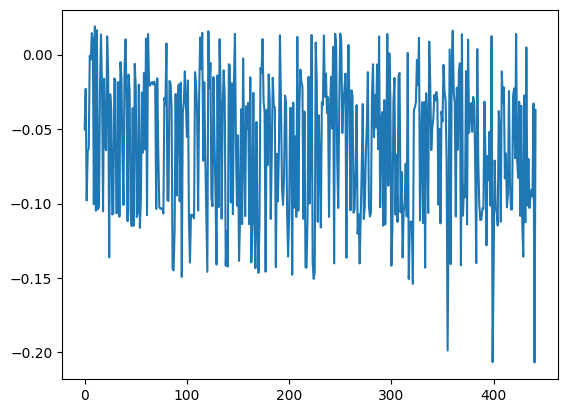

In [241]:
import matplotlib.pyplot as plt 

plt.plot(out_test["node_embedding"].detach().numpy())

In [245]:
print(batch.keys())

['coords', 'batch', 'chains', 'edge_type', 'fill_value', 'residue_id', 'edge_attr', 'pos', 'ptr', 'atom_list', 'id', 'x', 'num_relation', 'residue_type', 'edge_index', 'residues', 'label']


In [270]:
ge = out_test["graph_embedding"]
ne = out_test["node_embedding"]

In [279]:
import torch_geometric.nn as nn

#ge = ge.squeeze()
#ge_rep = ge.expand(ne.shape[0])
#ne = ne.squeeze()
#print(ge_rep.shape)
print(ne.shape)
print(ge.shape)
ge_rep = ge.expand(ne.shape)
print(ge_rep.shape)
res = torch.cat((ge_rep,ne),dim=1)
print("res shape: ",res.shape)

test_layer = nn.GCNConv(2,5)
#edge_indices = 
decoded = test_layer(res,edge_index = batch.edge_index)
print(decoded.shape)

torch.Size([442, 1])
torch.Size([1, 1])
torch.Size([442, 1])
res shape:  torch.Size([442, 2])
torch.Size([442, 5])


Does the output format change when using a proteinbatch? 

In [226]:
print(model.forward(gpt.data.ProteinBatch().from_batch(batch_featurised))) #absolutely the same, so no reason to use it 



{'node_embedding': tensor([[-0.0764],
        [-0.0025],
        [-0.0081],
        ...,
        [-0.0415],
        [ 0.0057],
        [ 0.0251]], grad_fn=<AddmmBackward0>), 'graph_embedding': tensor([[ -6.2992],
        [-22.7443],
        [ -8.3573],
        [-21.0849]], grad_fn=<ScatterAddBackward0>)}


No :)

In [281]:
import sys

sys.version

'3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]'